# Rendimento Difensori


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
from highlight_text import fig_text, ax_text
from adjustText import adjust_text
from PIL import Image
import scipy.stats as stats
import urllib
import os
import numpy as np

In [3]:
font_path = "../Grafici/assets/fonts/"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../Grafici/assets/stylesheets/soc_base.mplstyle")

In [4]:
df = pd.read_csv("./data/player_defensive.csv", sep='\t').set_index('Rk')#[['Player', '90s', ]]#.set_index('Rk')[['Player', 'Gls', 'Sh', '90s']]
#df.plot.scatter('Sh', 'Gls')
df = df[['Player', 'Squad', 'Pos', '90s', 'Tkl', 'TklW', 'Tkl.1', 'Tkl%']]
df = df[(df['90s'] > 10) & (df['Pos'] == 'DF') ]#.reset_index(drop=True)
df

,Player,Squad,Pos,90s,Tkl,TklW,Tkl.1,Tkl%
Rk,,,,,,,,
5,Francesco Acerbi,Inter,DF,26.6,33.0,19,20.0,74.1
11,Emanuel Aiwum,Cremonese,DF,17.4,54.0,33,32.0,69.6
15,Kelvin Amian,Spezia,DF,25.4,52.0,31,23.0,76.7
17,Bruno Amione,Sampdoria,DF,22.2,47.0,30,17.0,41.5
31,Tommaso Augello,Sampdoria,DF,33.0,17.0,14,9.0,45.0
...,...,...,...,...,...,...,...,...
559,Stefan de Vrij,Inter,DF,20.6,28.0,18,8.0,61.5
564,Przemysław Wiśniewski,Spezia,DF,10.1,12.0,6,5.0,33.3
568,Nicola Zalewski,Roma,DF,23.4,43.0,26,21.0,30.0


In [5]:
touches = pd.read_csv("./data/touches_against_def.csv", sep='\t').reset_index(drop=True)#[['Player', '90s', ]]#.set_index('Rk')[['Player', 'Gls', 'Sh', '90s']]
touches = touches[['Squad', 'Touches']]
touches

,Squad,Touches
0,Atalanta,23178
1,Bologna,20436
2,Cremonese,24588
3,Empoli,22360
4,Fiorentina,18603
5,Hellas Verona,23418
6,Inter,20520
7,Juventus,22701
8,Lazio,23109
9,Lecce,24069


In [6]:
# tackle padj = ( Tackle Scalvini * numero tocchi difensore ) / numero assoluto  di tocchi vs Atalanta
#touches_vs_team = touches['Squad']

'''
df = df.assign(tackle_padj = lambda x: x.Tkl * 100/x["90s"])
df = df.assign(Sh_90 = lambda x: x.Sh/x["90s"])
df
'''

for team in df['Squad'].unique():
    touches_vs_team = touches[touches['Squad'] == team]['Touches'].iloc[0]
    df.loc[df['Squad'] == team, 'p_adj'] = df.Tkl * 100 / touches_vs_team 

df = df.assign(perc_tkl_won = lambda x: round(x.TklW/x.Tkl*100, 1))
df

,Player,Squad,Pos,90s,Tkl,TklW,Tkl.1,Tkl%,p_adj,perc_tkl_won
Rk,,,,,,,,,,
5,Francesco Acerbi,Inter,DF,26.6,33.0,19,20.0,74.1,0.160819,57.6
11,Emanuel Aiwum,Cremonese,DF,17.4,54.0,33,32.0,69.6,0.219619,61.1
15,Kelvin Amian,Spezia,DF,25.4,52.0,31,23.0,76.7,0.233048,59.6
17,Bruno Amione,Sampdoria,DF,22.2,47.0,30,17.0,41.5,0.205716,63.8
31,Tommaso Augello,Sampdoria,DF,33.0,17.0,14,9.0,45.0,0.074408,82.4
...,...,...,...,...,...,...,...,...,...,...
559,Stefan de Vrij,Inter,DF,20.6,28.0,18,8.0,61.5,0.136452,64.3
564,Przemysław Wiśniewski,Spezia,DF,10.1,12.0,6,5.0,33.3,0.053780,50.0
568,Nicola Zalewski,Roma,DF,23.4,43.0,26,21.0,30.0,0.190122,60.5


## Visual

In [7]:
def plot_line(m, ax, **kwargs):
    op = lambda x: m*x
    x = [ax.get_ylim()[0]-5, ax.get_xlim()[1]+5]
    ax.plot(x, [op(x[0]), op(x[1])], **kwargs)

def ann(ax, pl, x=0, y=0):
    for i in pl.iloc:
        ax.annotate(i['Player'], xy=(i['p_adj']+x, i['perc_tkl_won']+y),#ax.annotate(i['Player'], xy=(0,0), xytext=(i['p_adj']+x, i['perc_tkl_won']+y), 
                    color = "black", font = "DM Sans", weight = "bold",
                   path_effects=[path_effects.Stroke(linewidth=2, foreground='#efe9e6'), 
                    path_effects.Normal()]
                    )


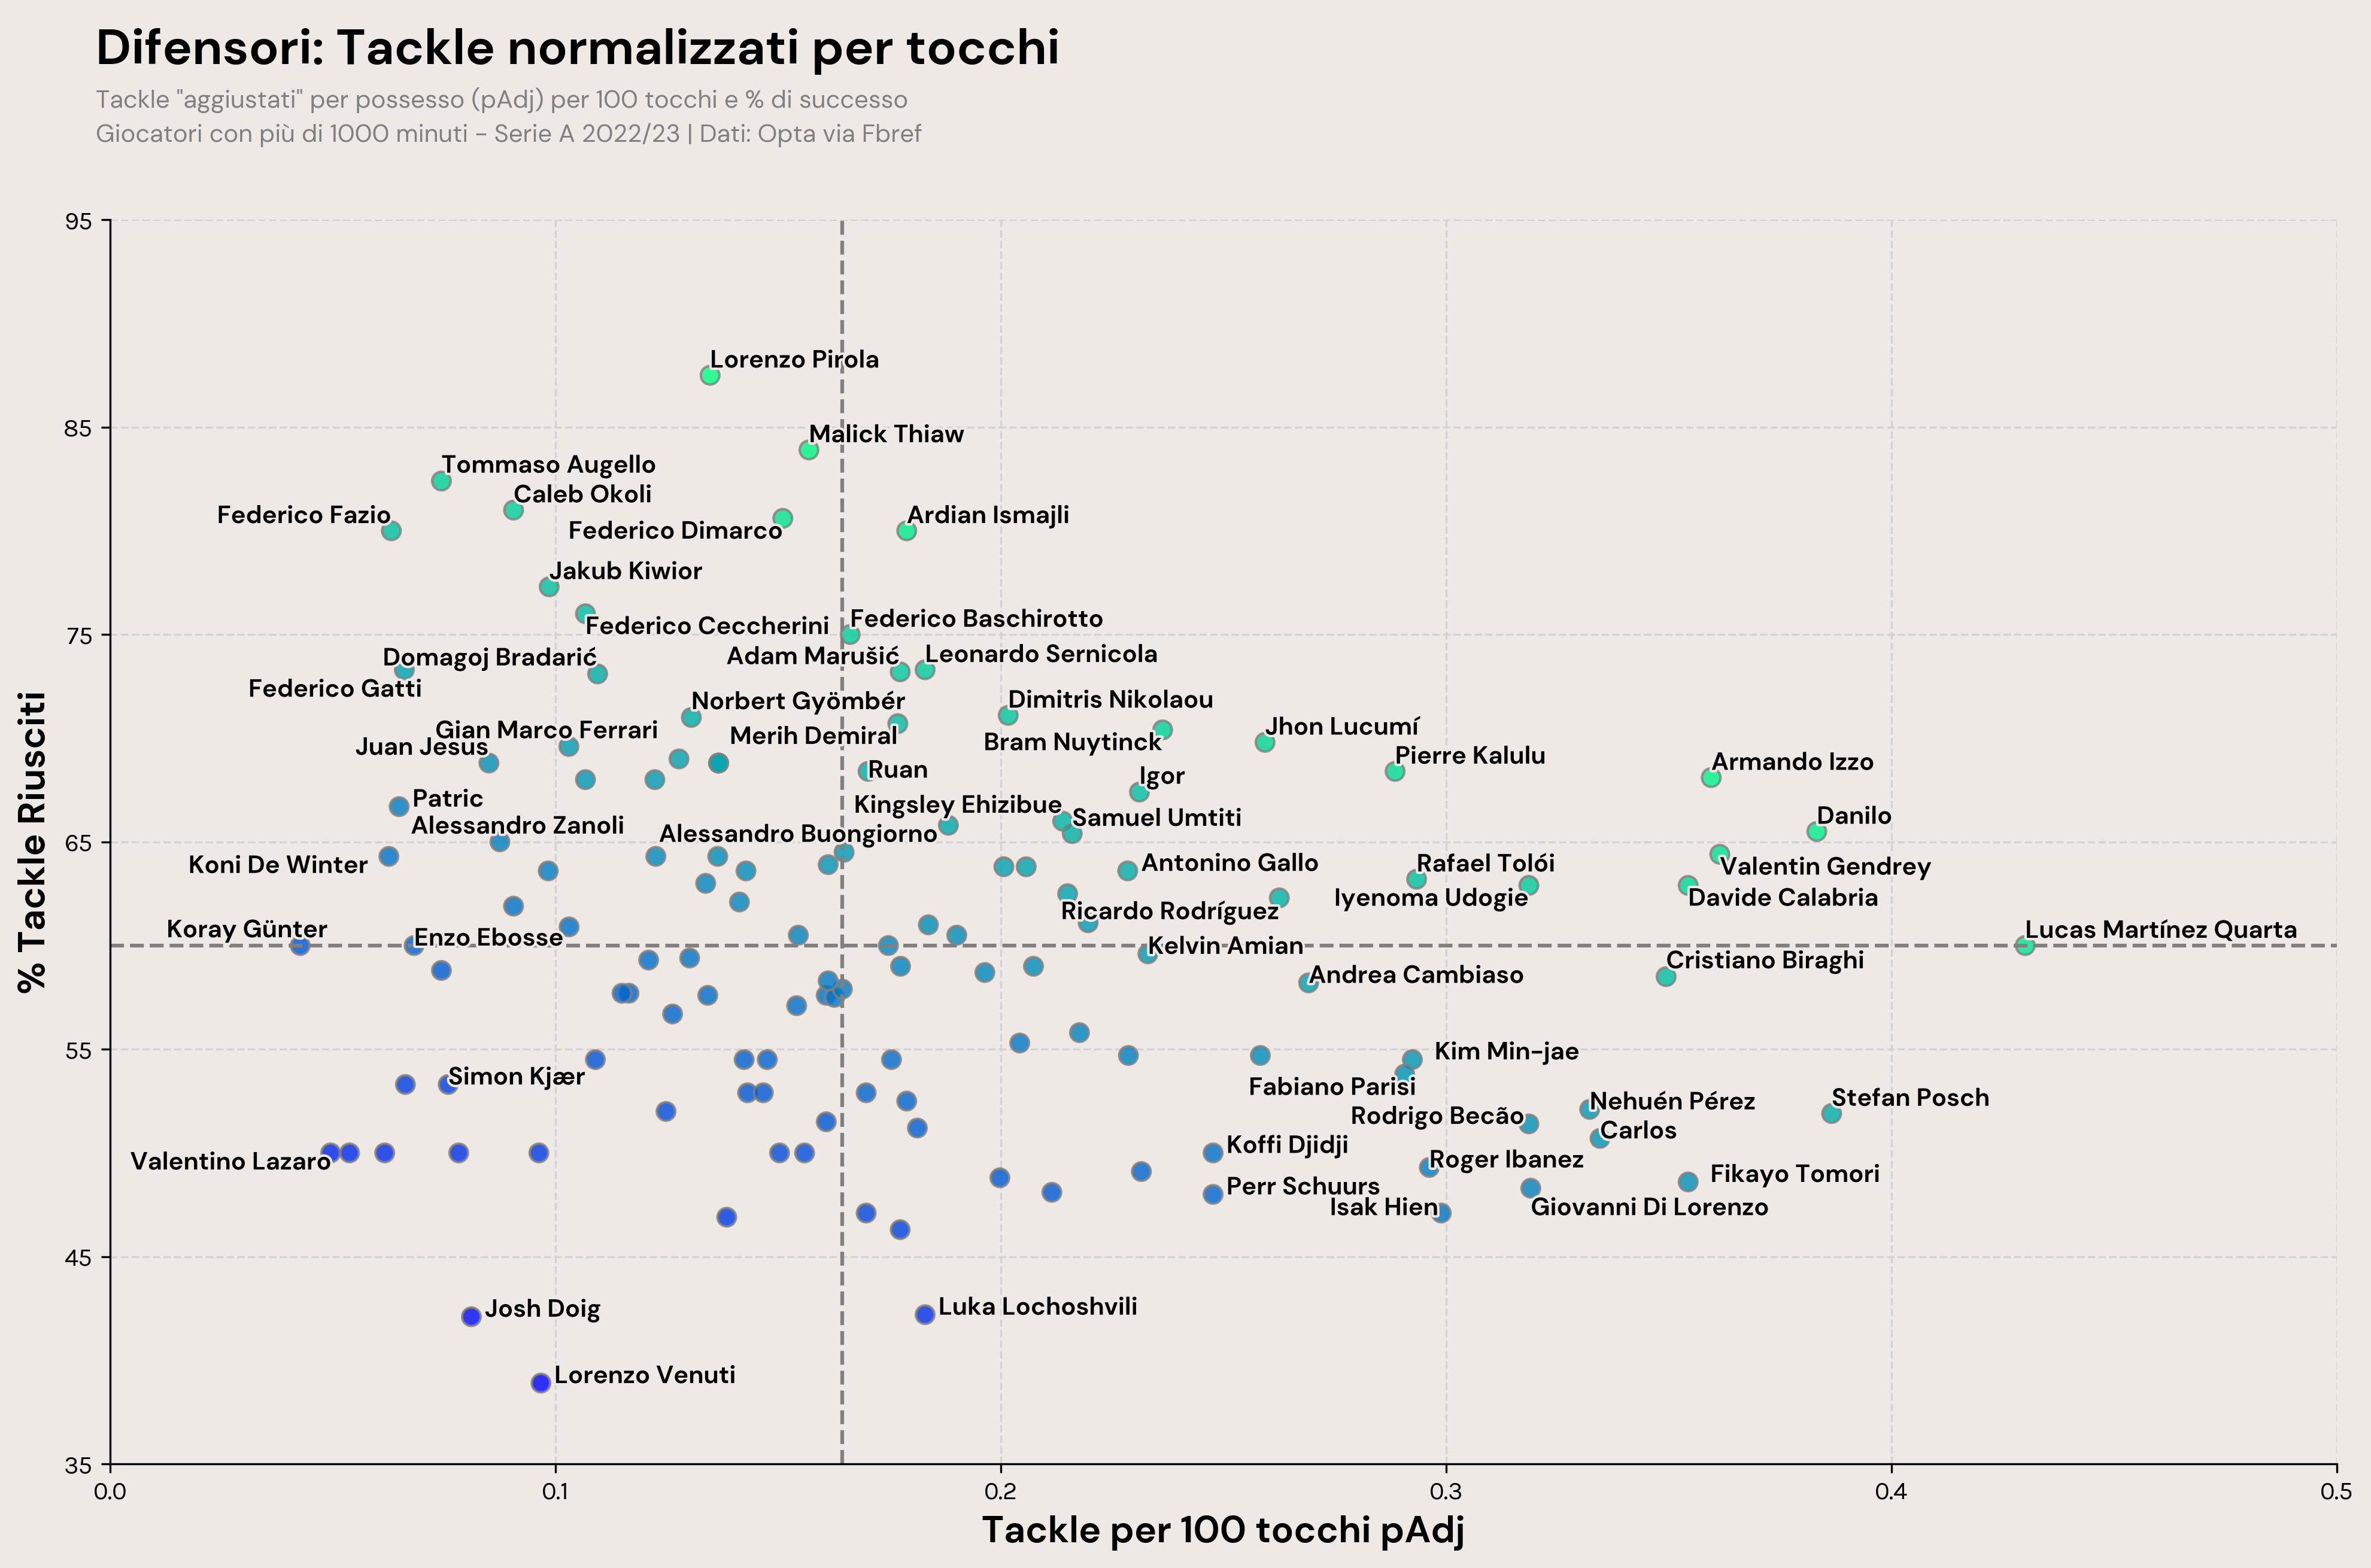

In [25]:
p = 0.4
df['zscore'] = stats.zscore(df['p_adj'])*p + stats.zscore(df['perc_tkl_won'])*(1-p)
df['annotated'] = [True if x > df['zscore'].quantile(.75)
                   else False for x in df['zscore']]


fig = plt.figure(figsize=(16, 9), dpi=300)
ax = plt.subplot()
ax.grid(visible=True, ls='--', color='lightgrey')

ax.set_xlabel("Tackle per 100 tocchi pAdj", fontsize = 15, color = "black", font = "DM Sans", weight = "bold")
ax.set_ylabel("% Tackle Riusciti",fontsize = 15, color = "black", font = "DM Sans", weight = "bold")

ax.xaxis.set_ticks([x for x in np.arange(0, 0.6, 0.1)])
ax.yaxis.set_ticks([x for x in np.arange(35, 96, 10)])

ann(ax, df[(df['p_adj'].between(0.05, 0.1)) & (df['perc_tkl_won'].between(72, 75))], -0.035, y=-1.3)
ann(ax, df[(df['p_adj'].between(0.34, 0.40)) & (df['perc_tkl_won'].between(46, 49))], 0.005)
ann(ax, df[(df['p_adj'].between(0.31, 0.32)) & (df['perc_tkl_won'].between(50, 55))], x=-0.04)
ann(ax, df[(df['p_adj'].between(0.33, 0.34)) & (df['perc_tkl_won'].between(50, 51))])
ann(ax, df[(df['p_adj'].between(0.33, 0.34)) & (df['perc_tkl_won'].between(51, 53))])
ann(ax, df[df.Player == "Kim Min-jae"], 0.005, 0.01)
ann(ax, df[df.Player == "Fabiano Parisi"], -0.035, -1)
ann(ax, df[df.Player == "Kelvin Amian"])#, -0.035, -1)
ann(ax, df[df.Player == "Andrea Cambiaso"])#, -0.035, -1)
ann(ax, df[df.Player == "Giovanni Di Lorenzo"], y=-1.3)
ann(ax, df[df.Player == "Isak Hien"], -0.025, -0.1)
ann(ax, df[df.Player == "Roger Ibanez"])#, -0.035, -1)
ann(ax, df[df.Player == "Josh Doig"], 0.003)
ann(ax, df[df.Player == "Luka Lochoshvili"], 0.003)
ann(ax, df[df.Player == "Lorenzo Venuti"], 0.003)
#ann(ax, df[df.Player == "Flavius Daniliuc"], -0.035, 0.8)
ann(ax, df[df.Player == "Koffi Djidji"], 0.003)
ann(ax, df[df.Player == "Perr Schuurs"], 0.003)
ann(ax, df[df.Player == "Alessandro Buongiorno"], -0.065, -0.8)
ann(ax, df[df.Player == "Norbert Gyömbér"], y=0.4)
ann(ax, df[df.Player == "Juan Jesus"], x=-0.03, y=0.4)
ann(ax, df[df.Player == "Gian Marco Ferrari"], x=-0.03, y=0.4)
ann(ax, df[df.Player == "Antonino Gallo"], 0.003)
ann(ax, df[df.Player == "Patric"], 0.003)
ann(ax, df[df.Player == "Koray Günter"], x=-0.03, y=0.4)
ann(ax, df[df.Player == "Alessandro Zanoli"], -0.02, 0.4)
ann(ax, df[df.Player == "Enzo Ebosse"])
ann(ax, df[df.Player == "Simon Kjær"])
ann(ax, df[df.Player == "Valentino Lazaro"], x=-0.045, y=-0.8)
ann(ax, df[df.Player == "Koni De Winter"], x=-0.045, y=-0.8)

args = dict(color="#3A3A3A", font="DM Sans", weight="bold",
           path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()])

ax.set_ylim(35, 95)
ax.set_xlim(0, 0.5)

ax.scatter(
    df['p_adj'], df['perc_tkl_won'],
    c=df['zscore'], cmap='winter', 
    zorder=2, ec='grey', s=55, alpha=0.8
)

texts = []
annotated_df = df[df['annotated']].reset_index(drop=True)
for index in range(annotated_df.shape[0]):
    texts += [
        ax.text(
            x=annotated_df['p_adj'].iloc[index], y=annotated_df['perc_tkl_won'].iloc[index],
            s=f"{annotated_df['Player'].iloc[index]}",
            path_effects=[path_effects.Stroke(linewidth=2, foreground=fig.get_facecolor()), 
            path_effects.Normal()], color='black',
            family='DM Sans', weight='bold'
        )
    ]

adjust_text(texts, only_move={'points':'y', 'text':'xy', 'objects':'xy'})

ax.axhline(y=df['perc_tkl_won'].median(), ls='--', color='grey')
ax.axvline(x=df['p_adj'].median(), ls='--', color='grey')

#plt.plot()

'''
plot_line(1/20, ax, color='grey', ls='--')
plot_line(1/6, ax, color='grey', ls='--')
plot_line(1/3, ax, color='grey', ls='--')
'''

fig_text(
    x = 0.12, y = .97, 
    s = 'Difensori: Tackle normalizzati per tocchi',
    va = 'bottom', ha = 'left',
    fontsize = 20, color = 'black', fontname="DM Sans", weight = 'bold'
)

fig_text(
    x = 0.12, y = 0.925, 
    s = 'Tackle "aggiustati" per possesso (pAdj) per 100 tocchi e % di successo\nGiocatori con più di 1000 minuti - Serie A 2022/23 | Dati: Opta via Fbref',
    va = 'bottom', ha = 'left',
    fontsize = 10, font = 'DM Sans', color = 'gray'
)

plt.savefig(
	"figures/Players_Tackles_Defenders.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/Players_Tackles_Defenders_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)


In [9]:
df[(df['p_adj'].between(0.05, 0.07)) & (df['perc_tkl_won'].between(64, 65))]


,Player,Squad,Pos,90s,Tkl,TklW,Tkl.1,Tkl%,p_adj,perc_tkl_won,zscore,annotated
Rk,,,,,,,,,,,,
152,Koni De Winter,Empoli,DF,11.4,14.0,9,5.0,38.5,0.062612,64.3,-0.304633,False


In [10]:
#df[(df['p_adj'].between(0.3, 0.32)) & (df['perc_tkl_won'].between(45, 50))]
#df[(df['p_adj'].between(0.29, 0.3)) & (df['perc_tkl_won'].between(47, 48))]
df[(df['p_adj'].between(0.29, 0.3)) & (df['perc_tkl_won'].between(49, 50))]

,Player,Squad,Pos,90s,Tkl,TklW,Tkl.1,Tkl%,p_adj,perc_tkl_won,zscore,annotated
Rk,,,,,,,,,,,,
250,Roger Ibanez,Roma,DF,31.1,67.0,33,32.0,66.7,0.296237,49.3,-0.144149,False
